In [1]:
%pip install networkx
%pip install matplotlib
%pip install tqdm
%pip install pandas
%pip install numpy
%pip install graphviz
%pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you 

In [2]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby
import time
from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [3]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

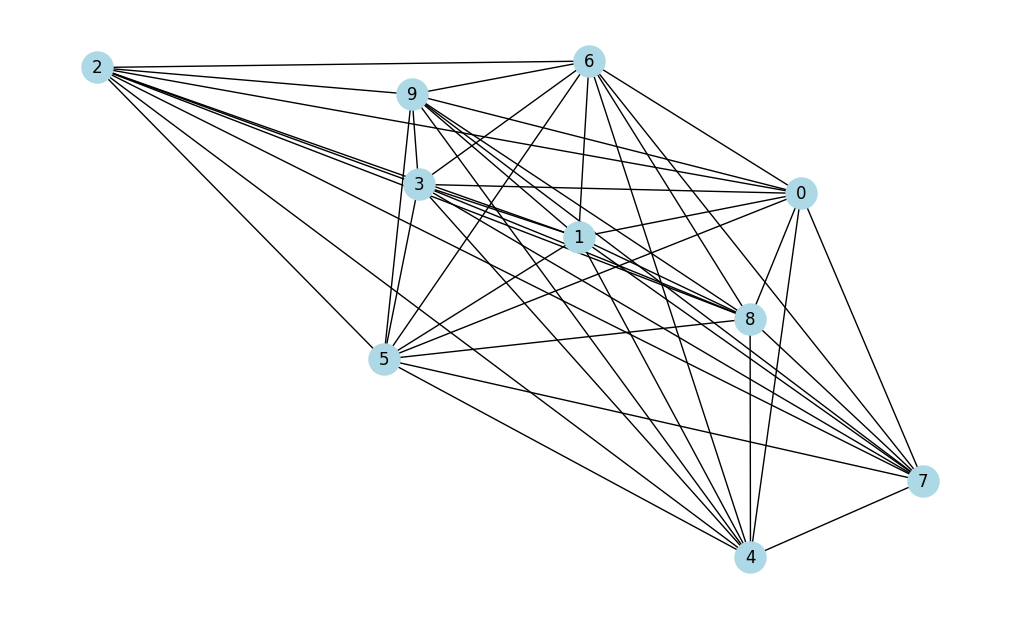

In [5]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [6]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

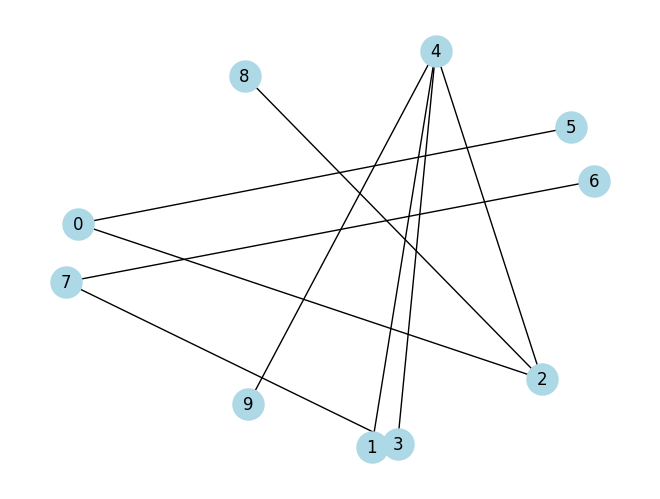

In [7]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [8]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 2), (0, 5), (1, 4), (2, 8), (2, 4), (3, 4), (3, 7), (4, 9), (6, 7)]),
 9)

In [10]:
"""Algorythm Kruskal"""
class DisjointSet:
    """
    A data structure to manage disjoint sets with path compression and union by rank.
    """
    def __init__(self, n: int):
        """
        Initialization of values
        """
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, u: int) -> int:
        """
        Finds the representative (root) of the set that `u` belongs to,
        using path compression for optimization.
        """
        while self.parent[u] != u:
            self.parent[u] = self.parent[self.parent[u]]
            u = self.parent[u]
        return u

    def union(self, u: int, v: int):
        """
        Merges the sets that contain `u` and `v` using union by rank.
        """
        root_u = self.find(u)
        root_v = self.find(v)
        if root_u != root_v:
            if self.rank[root_u] > self.rank[root_v]:
                self.parent[root_v] = root_u
            elif self.rank[root_u] < self.rank[root_v]:
                self.parent[root_u] = root_v
            else:
                self.parent[root_v] = root_u
                self.rank[root_u] += 1

def kruskal_mst(graph) -> list[tuple[int, int, int]]:
    """
    Computes the Minimum Spanning Tree (MST) of a given graph using Kruskal's algorithm.
    """
    edges = [(u, v, d['weight']) for u, v, d in graph.edges(data=True)]
    edges.sort(key=lambda x: x[2])
    ds = DisjointSet(len(graph.nodes))
    mst = []
    for u, v, weight in edges:
        if ds.find(u) != ds.find(v):
            ds.union(u, v)
            mst.append((u, v, weight))
    return mst



In [11]:
def measure_time(graph, algorithm_func) -> float:
    """
    Measures the execution time of a given algorithm applied to a graph.
    """
    start_time = time.time()
    algorithm_func(graph)
    return time.time() - start_time

num_nodes_list = [10, 20, 50, 100, 200, 500]
edge_probabilities = [0.2, 0.5, 0.8]
results = []
kruskal_times = []
nx_kruskal_times = []

for num_nodes in num_nodes_list:
    for edge_prob in edge_probabilities:
        G = nx.gnp_random_graph(num_nodes, edge_prob)
        for (u, v) in G.edges():
            G.edges[u, v]['weight'] = random.randint(1, 100)

        time_kruskal = measure_time(G, kruskal_mst)
        time_nx_kruskal = measure_time(G, nx.minimum_spanning_tree)

        results.append((num_nodes, edge_prob, time_kruskal, time_nx_kruskal))
        kruskal_times.append(time_kruskal)
        nx_kruskal_times.append(time_nx_kruskal)

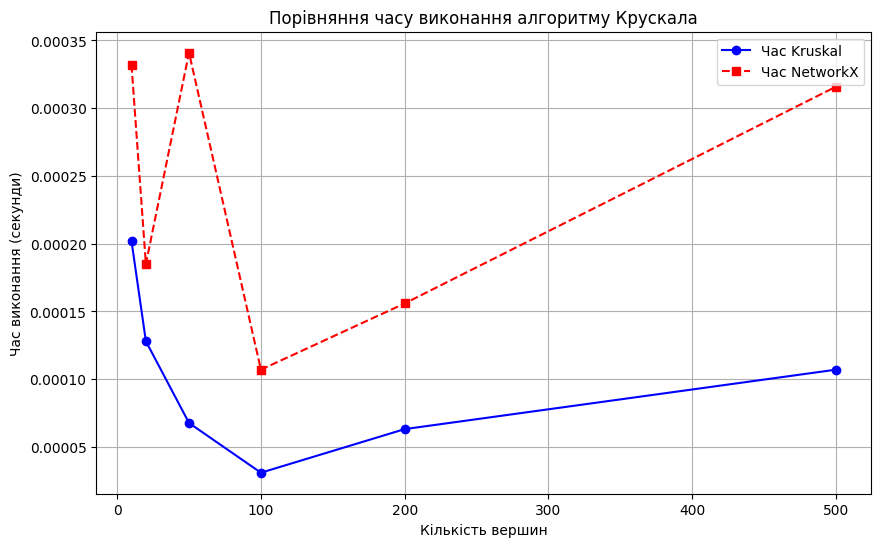

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(num_nodes_list, kruskal_times[:len(num_nodes_list)], marker='o', linestyle='-', color='b', label="Час Kruskal")
plt.plot(num_nodes_list, nx_kruskal_times[:len(num_nodes_list)], marker='s', linestyle='--', color='r', label="Час NetworkX")
plt.xlabel("Кількість вершин")
plt.ylabel("Час виконання (секунди)")
plt.title("Порівняння часу виконання алгоритму Крускала")
plt.legend()
plt.grid()
plt.show()

### Звіт до алгоритму Крускала

#### Опис функцій у коді

DisjointSet – структура для об’єднання та пошуку (Union-Find), яка допомагає ефективно обробляти компоненти зв’язності під час виконання алгоритму Крускала.

	- find(u): знаходить кореневий вузол множини, до якої належить u, з використанням стиснення шляху.
	- union(u, v): об’єднує множини, до яких належать u і v, з використанням рангу.
kruskal_mst(graph) – реалізація алгоритму Крускала для знаходження мінімального остовного дерева (MST).

	- Сортує ребра за вагою.
	- Використовує DisjointSet для перевірки циклів.
	- Додає ребра до MST, якщо вони не створюють циклу.

measure_time(graph, algorithm_func) – вимірює час виконання алгоритму, використовуючи time.time().

#### Основний цикл тестування:
1. Створюються випадкові графи з кількістю вершин від 10 до 500.
2. Використовуються три рівні щільності графа (ймовірність ребра 0.2, 0.5, 0.8).
3. Для кожного графа виконується алгоритм Крускала і вбудований метод networkx.minimum_spanning_tree().
4. Час виконання кожного методу записується та використовується для побудови графіка.

#### Візуалізація та результати:

При побудові графіка порівняння часу виконання обох алгоритмів можна зробити кілька важливих висновків:

	• Власна реалізація алгоритму Крускала виявляється швидшою за вбудований метод networkx.minimum_spanning_tree(), незалежно від кількості вершин графа
	• Зміни в часі виконання стають помітними, коли кількість вершин перевищує 100. При збільшенні числа вершин до 200 і більше, різниця між часами виконання обох алгоритмів суттєво зростає
Отже, можна зробити висновок, що хоча вбудований метод networkx може бути оптимізованим для певних випадків, алгоритм Крускала залишається значно швидшим при обробці графів з будь-яким розміром і щільністю.


### Prim's algorithm

In [13]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

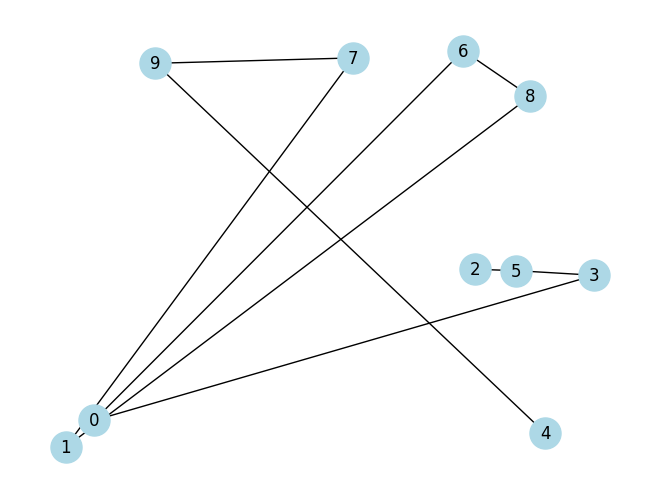

In [ ]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [10]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 6), (0, 3), (1, 8), (1, 7), (2, 5), (3, 5), (4, 9), (6, 8), (7, 9)]),
 9)

*put your code below* (delete this)

## Subtask 1.2

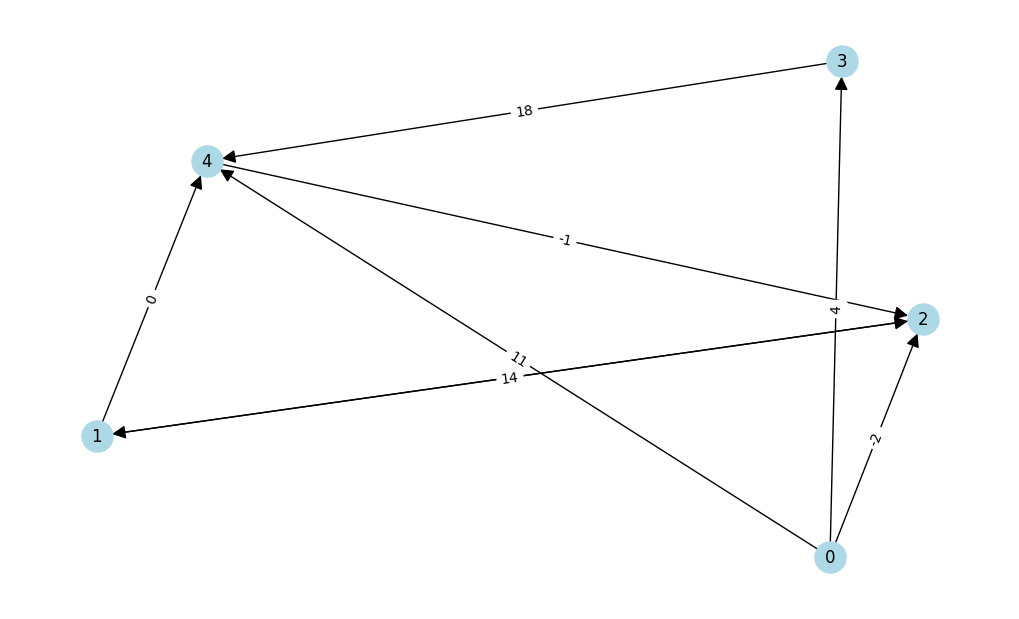

In [14]:
G = gnp_random_connected_graph(5, 0.5, True, True)

### Bellman-Ford algorithm

In [15]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    print(pred)
    print(f'{dist=}')
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

{0: [], 3: [0], 2: [0], 4: [0], 1: [2]}
dist={0: 0, 3: 4, 2: -2, 4: 11, 1: 12}
Distance to 0: 0
Distance to 3: 4
Distance to 2: -2
Distance to 4: 11
Distance to 1: 12


In [16]:
def bellman_ford_algo(graph, start_node: any) -> tuple[dict,dict]:
	"""
	Implements the Bellman-Ford algorithm to find the shortest paths from a start node to all other reachable nodes.
	"""
	edges_with_data = list(graph.edges(data=True))
	res_dist = { n: float("inf") for n in graph.nodes()}
	pred = {n: [] for n in graph.nodes()}
	
	res_dist[start_node] = 0
    
	for _ in range(len(graph.nodes()) - 1):
		flag = False
		for from_, to_, w in edges_with_data:
			new_dist = res_dist[from_] + w['weight']
			if new_dist < res_dist[to_]:
				res_dist[to_] = new_dist
				pred[to_] = [from_]
				flag = True
			elif new_dist == res_dist[to_] and from_ not in pred[to_]:
				pred[to_].append(from_)
				flag = True
		if not flag:
			break

	for from_, to_, w in edges_with_data:
		if res_dist[from_] != float("inf") and res_dist[from_] + w['weight'] < res_dist[to_]:
				raise ValueError

	for n in graph.nodes():
		if n == start_node:
			continue
		if res_dist[n] == float("inf") or pred[n] == []:
			del res_dist[n]
			del pred[n]

	return pred,res_dist

try:
    pred, dist = bellman_ford_algo(G, 0)
    print(f'{pred=}')
    print(f'{dist=}')
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")


pred={0: [], 1: [2], 2: [0], 3: [0], 4: [0]}
dist={0: 0, 1: 12, 2: -2, 3: 4, 4: 11}
Distance to 0: 0
Distance to 1: 12
Distance to 2: -2
Distance to 3: 4
Distance to 4: 11


In [18]:
def measure_time(algorithm_func, g, start_node: int) -> float:
    """Measures the execution time of a given algorithm applied to a graph."""
    start_time = time.time()
    algorithm_func(g, start_node)
    return time.time() - start_time
num_nodes_list = [10, 20, 50, 100, 200, 500]
edge_probabilities = [0.2, 0.5, 0.8]

results = []
bellman_ford_times = []
nx_bellman_times = []
for num_nodes in num_nodes_list:
    for edge_prob in edge_probabilities:
        G = nx.gnp_random_graph(num_nodes, edge_prob, directed=True)
        for (u, v) in G.edges():
            G.edges[u, v]['weight'] = random.randint(1, 100)
        start_node = 0
        time_bellman_ford = measure_time(bellman_ford_algo, G, start_node)
        time_nx_bellman_ford = measure_time(nx.single_source_bellman_ford, G, start_node)

        results.append((num_nodes, edge_prob, time_bellman_ford, time_nx_bellman_ford))
        bellman_ford_times.append(time_bellman_ford)
        nx_bellman_times.append(time_nx_bellman_ford)

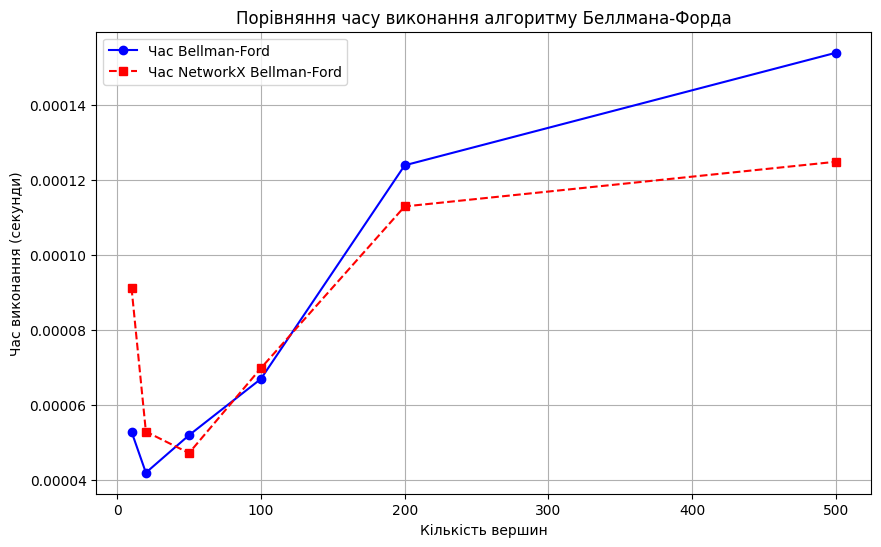

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(num_nodes_list, bellman_ford_times[:len(num_nodes_list)], marker='o', linestyle='-', color='b', label="Час Bellman-Ford")
plt.plot(num_nodes_list, nx_bellman_times[:len(num_nodes_list)], marker='s', linestyle='--', color='r', label="Час NetworkX Bellman-Ford")
plt.xlabel("Кількість вершин")
plt.ylabel("Час виконання (секунди)")
plt.title("Порівняння часу виконання алгоритму Беллмана-Форда")
plt.legend()
plt.grid()
plt.show()

### Звіт щодо аналізу виконання алгоритмів Беллмана-Форда

### Опис функцій у коді:
bellman_ford_algo(graph, start_node) — реалізація алгоритму Беллмана-Форда для пошуку найкоротших шляхів від початкової вершини до всіх інших досяжних вершин графа.
	
	• Створюється словник res_dist, де зберігаються мінімальні відстані від початкової вершини до інших вершин, з початковими значеннями, рівними нескінченності. Також cтворюється словник pred, який зберігає попередні вершини для кожної вершини в шляху (щоб можна було відтворити кінцевий шлях).
	• Алгоритм виконується len(graph.nodes()) разів - к-сть вершин, оновлюючи відстані та попередні вершини, поки не буде досягнуто стабільності або поки не цикл не закінчиться.
	• Якщо в графі є від’ємні цикли, алгоритм Беллмана-Форда не працює.

measure_time(algorithm_func, g, start_node) — вимірює час виконання заданого алгоритму на графі.

	• Вимірюється час роботи алгоритму, використовуючи функцію time.time().

#### Основний цикл тестування:
	1. Для кожного з наборів параметрів (кількість вершин і ймовірність наявності ребер) створюється випадковий орієнтований граф.
	2. Для кожного графа генеруються випадкові ваги для ребер в діапазоні від 1 до 100.
	3. Виконуються тести для двох реалізацій алгоритму Беллмана-Форда:
		• Власна реалізація bellman_ford_algo.
		• Вбудований метод networkx.single_source_bellman_ford.
	4. Час виконання кожного алгоритму записується та порівнюється.

#### Візуалізація та результати:

Після побудови графіків порівняння часу виконання обох алгоритмів можна зробити наступні висновки:

	• До 100 вершин обидва алгоритми працюють приблизно однаково, при цьому в окремих випадках власна реалізація алгоритму Беллмана-Форда виявляється трохи швидшою за вбудований метод.
	• Від 100 до 200 вершин і більше, час виконання обох алгоритмів різко збільшується, і на цих етапах власна реалізація алгоритму значно повільніша порівняно з вбудованим методом networkx.single_source_bellman_ford.

Таким чином, хоча обидва алгоритми показують подібну продуктивність для малих графів (до 100 вершин), власна реалізація алгоритму Беллмана-Форда демонструє суттєві проблеми з масштабуванням при більших графах, що вказує на перевагу вбудованого алгоритму для великих графів.

### Floyd-Warshall algorithm

In [13]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 1: 8, 9: 6, 2: inf, 3: inf, 4: inf, 5: 13, 6: 11, 7: 8, 8: 3}
Distances with 1 source: {1: 0, 6: 3, 7: 0, 8: -5, 9: 6, 0: inf, 2: inf, 3: inf, 4: inf, 5: 13}
Distances with 2 source: {2: 0, 3: -4, 4: 20, 6: 3, 7: 0, 0: inf, 1: 0, 5: 8, 8: -9, 9: 2}
Distances with 3 source: {3: 0, 1: 4, 9: 6, 5: 12, 8: -5, 0: inf, 2: inf, 4: inf, 6: 7, 7: 4}
Distances with 4 source: {4: 0, 5: -4, 6: 13, 7: 10, 8: 5, 0: inf, 1: inf, 2: inf, 3: inf, 9: 4}
Distances with 5 source: {5: 0, 8: 17, 9: 8, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 6: inf, 7: inf}
Distances with 6 source: {6: 0, 9: 3, 7: -3, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: 10, 8: -8}
Distances with 7 source: {7: 0, 9: 6, 8: -5, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: 13, 6: inf}
Distances with 8 source: {8: 0, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 9: inf}
Distances with 9 source: {9: 0, 5: 7, 8: 9, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 6: inf, 7: inf}


*put your code below* (delete this)

---

## Some useful explanations
### How to get list of edges for your algorithm

In [29]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [30]:
edges[:5]

[(0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]

### To get edges with weights

In [31]:
edges = list(G.edges(data=True))

In [32]:
edges[:5]

[(0, 2, {'weight': 3}),
 (1, 2, {'weight': 3}),
 (1, 3, {'weight': 8}),
 (2, 4, {'weight': 16}),
 (3, 4, {'weight': 3})]

In [33]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [12]:
import time
from tqdm import tqdm

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


1.4066696166992188e-05

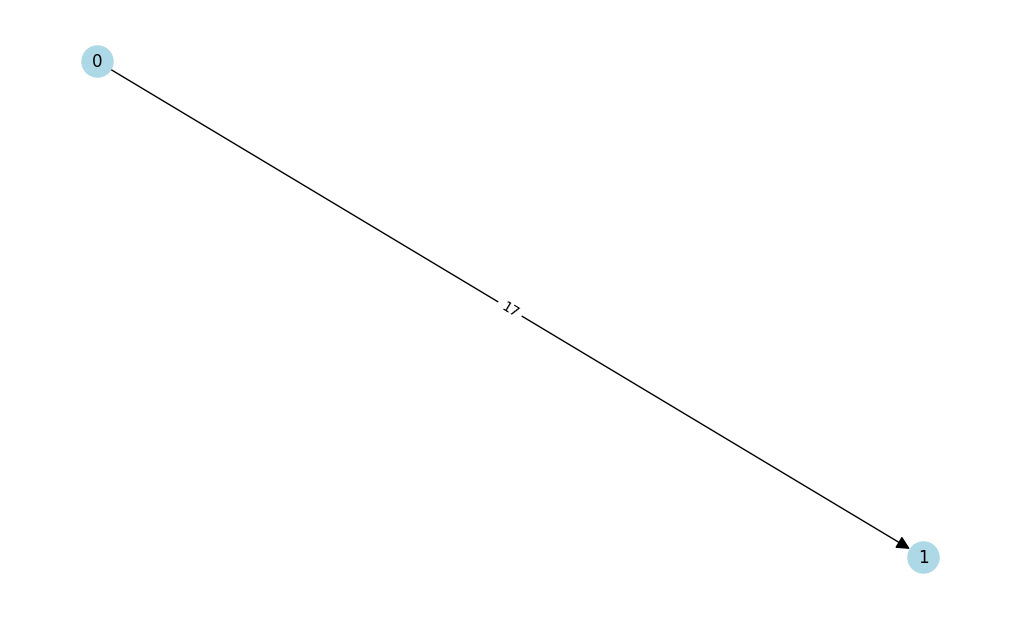

In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

## Task 2. Decision Tree Classifier 

In [20]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [56]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [57]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [58]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

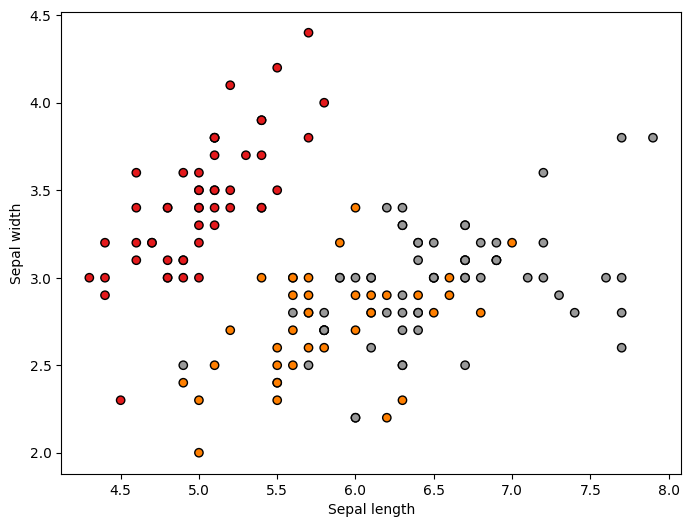

In [59]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [60]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [29]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [30]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [41]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

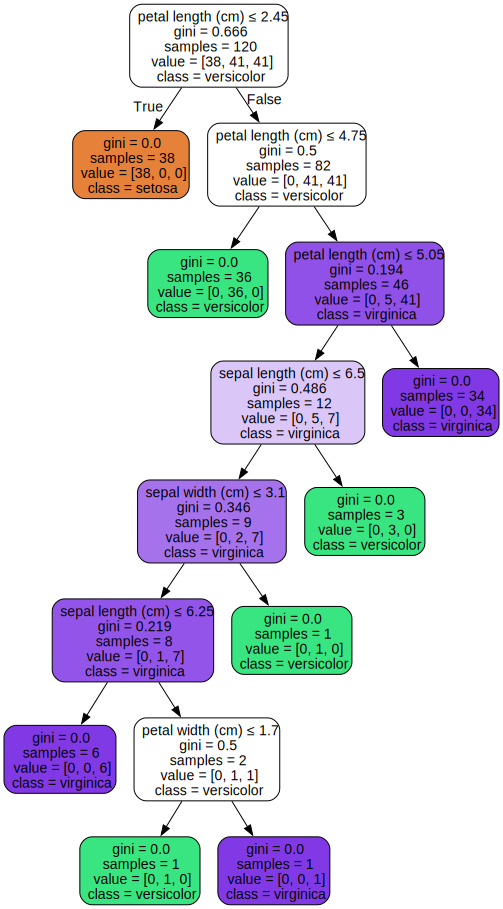

In [42]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [33]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [34]:
sum(predictions == y_test) / len(y_test)

np.float64(0.9333333333333333)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [35]:
y_test

array([0, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 0, 1, 1,
       0, 0, 2, 2, 1, 0, 1, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [36]:
X_test[1]

array([5.5, 2.3, 4. , 1.3])

In [61]:
clf.predict([X_test[1]])

NameError: name 'X_test' is not defined

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [21]:
class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray, feature_index=None, threshold=None, left=None, right=None, info=None, value=None):
        """
        :param X: numpy array of shape (n_samples, n_features), representing the feature values of the dataset.
        :param y: numpy array of shape (n_samples,), representing the target class labels.
        :param feature_index: Index of the feature used for the split at this node (None for leaf nodes).
        :param threshold: The threshold value for splitting the data (None for leaf nodes).
        :param left: Reference to the left child node (None for leaf nodes).
        :param right: Reference to the right child node (None for leaf nodes).
        :param info: Information gain of the split at this node (None for leaf nodes).
        :param value: Predicted class for leaf nodes; None for non-leaf nodes.
        """

        self.X = X
        self.y = y
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info = info
        self.value = value  # для листків

In [23]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        """Tree initialization"""
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size

        # перший раз запускаємо рекурсії, тому з 0 починати будемо
        self.tree = self.build_tree(X, y, depth=0)


    def build_tree(self, X, y, depth):
        """
        Recursively builds a decision tree by selecting the best split at each step.

        The process stops when the maximum depth is reached or when all samples belong 
        to the same class. If no beneficial split is found, a leaf node is created.
        """
        _, num_type = X.shape
        
        # зупиняємо коли або дуже довго/ макс глибина перевищена, або все вже з одного класу/типу 
        # тоді створюємо листок 
        if depth >= self.max_depth or len(set(y)) == 1:
            return Node(X, y, value= max(set(y), key=list(y).count))
        

        best_split = self.get_best_split(X, y, num_type)
        if best_split["info"] == 0:
            return Node(X, y, value= max(set(y), key=list(y).count))
        
        left_tree = self.build_tree(best_split["X_left"], best_split["y_left"], depth + 1)
        right_tree = self.build_tree(best_split["X_right"], best_split["y_right"], depth + 1)
        
        return Node(X, y, feature_index=best_split["type_ind"], threshold=best_split["threshold"],
                    left=left_tree, right=right_tree, info=best_split["info"])


    def get_best_split(self, X, y, num_type):
        """
        Finds the best split for the dataset by evaluating all features and thresholds.

        Iterates through all feature indices and unique threshold values to determine 
        the split that results in the highest information gain.
        """

        best_split = {"info": 0}
        max_info = float("-inf")
        
        for type_ind in range(num_type):
            # вибираємо всі значення ознаки з type_ind у X і чекаємо їх
            for threshold in np.unique(X[ : , type_ind]):
                X_left, y_left, X_right, y_right = self.split(X, y, type_ind, threshold)
                
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                info = self.gain_info(y, y_left, y_right)

                if info > max_info:
                    best_split = {"type_ind": type_ind, "threshold": threshold, "X_left": X_left, "y_left": y_left, "X_right": X_right, "y_right": y_right, "info": info}
                    max_info = info
        
        return best_split


    def split(self, X, y, feature_index, threshold):
        """
        Splits the dataset into two subsets based on the given feature and threshold.
        """
        X_feature = X[:, feature_index] 
        left_ = X_feature <= threshold  # ліва підмножина 
        right_ = X_feature > threshold  # права підмножина

        return X[left_], y[left_], X[right_], y[right_]
    
    
    def gain_info(self, parent, left_child, right_child):
        """
        Computes the information gain by measuring the reduction in impurity after a split.

        The gain is calculated as the difference between the impurity of the parent node 
        and the weighted sum of the impurities of the child nodes.
        """
        weight_l = len(left_child) / len(parent)
        weight_r = len(right_child) / len(parent)
        return self.gini_ind(parent) - (weight_l * self.gini_ind(left_child) + weight_r * self.gini_ind(right_child))
    
    def gini_ind(self, y):
        """Generates a Gini index"""
        _, counts = np.unique(y, return_counts=True)
        return 1 - np.sum((counts / len(y)) ** 2)




# для evaluate

    def make_prediction_for_class(self, el, node):
        """
        Traverses the decision tree recursively to predict the class label.

        The function follows the tree based on feature values until it reaches a leaf node, 
        returning the predicted class.
        """
        if node.value is not None:
            return node.value

        if el[node.feature_index] <= node.threshold:
            return self.make_prediction_for_class(el, node.left)
        else:
            return self.make_prediction_for_class(el, node.right)

    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        return [self.make_prediction_for_class(el, self.tree) for el in X_test]
    

In [24]:

def evaluate(our_tree: DecisionTreeClassifier, X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    predictions = our_tree.predict(np.array(X_test))
    correct = sum(el == y_test[ind] for ind,el in enumerate(predictions))
    return correct / len(y_test)

In [25]:
# перевіряємо чи все працює, вище це все писали 

iris = load_iris()
X, y = iris.data, iris.target

X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)

our_tree = DecisionTreeClassifier(max_depth=1000)

our_tree.fit(X, y)

accuracy = evaluate(our_tree, X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.97


### Звіт щодо реалізації Decision Tree

- __init__ – ініціалізує вузол дерева.
- fit – запускає процес побудови дерева.
- build_tree – рекурсивно будує дерево рішень.
- get_best_split – знаходить найкраще розбиття даних.
- split – ділить дані за ознакою та порогом.
- gain_info – обчислює приріст інформації.
- gini_ind – рахує індекс Джині для вузла.
- make_prediction_for_class – робить передбачення для одного елемента.
- predict – передбачає класи для тестових даних.
- evaluate – обчислює точність моделі (дерева), порівнюючи передбачені та реальні значення.